### homework 2 - part 2

the goal of this part is to build a CNN that where both the input and the output are images

the dataset is made from the dogs vs. cats dataset
https://www.kaggle.com/c/dogs-vs-cats

but its just the cats.

the dataloader adds random noise to the image, and the network task is to remove that noise, recovering the original image

download the cat image dataset from this link:

In [1]:
!wget https://www.dropbox.com/s/z90tvet2q97n350/cats.npy

In [1]:
%load_ext autoreload
%autoreload 2

(if its not avaliable on your system, install scikit-image)


https://scikit-image.org/docs/dev/install.html


In [5]:
#pip install scikit-image

In [2]:
from cats_dataloader import CatsWithNoiseDataset

In [3]:
train_ds = CatsWithNoiseDataset('cats.npy',0,800)
valid_ds = CatsWithNoiseDataset('cats.npy',800,1000)

In [4]:
import matplotlib.pyplot as plt

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


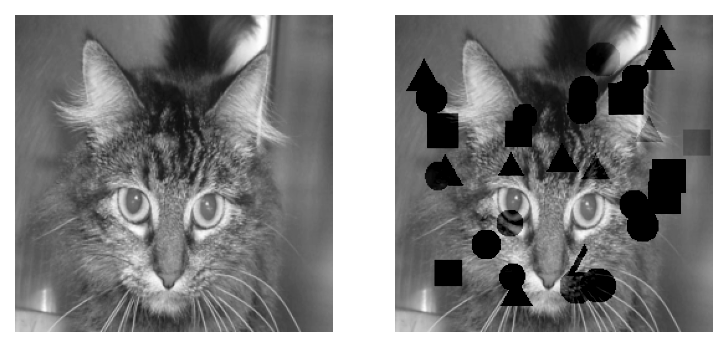

In [5]:
x, y = train_ds[433]
print(x.shape,y.shape)


fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=150)

ax[0].imshow(y[0],cmap='gist_yarg',vmin=0,vmax=1)
ax[1].imshow(x[0],cmap='gist_yarg',vmin=0,vmax=1)

for i in range(2):
    ax[i].set_axis_off()

plt.show()

In [6]:
from torch.utils.data import Dataset, DataLoader

training_dataloader = DataLoader(train_ds,batch_size=4,shuffle=True)
valid_dataloader = DataLoader(valid_ds,batch_size=20)

In [7]:
for x,y in training_dataloader:
    print(x.shape,y.shape)
    break

torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])


### we need to build a model that takes the image as input, and outputs an image of the same size

In [38]:
import torch.nn as nn

conv_layer = nn.Conv2d(1,50,3,padding=1,bias=False)  # input_channels, output_channels, conv_filter_size, padding
# padding=1 means add column of zero before the first column and after the last column,
# so size in these dimensions increae by 2.
# Bias is set to False because the conv layer goes to a BatchNorm.

In [39]:
x.shape

torch.Size([4, 1, 256, 256])

In [40]:
conv_layer(x).shape

torch.Size([4, 50, 256, 256])

#### build something that takes an image as input and returns an image of the same size as output.

IMG_05078C1BBF12-1.jpeg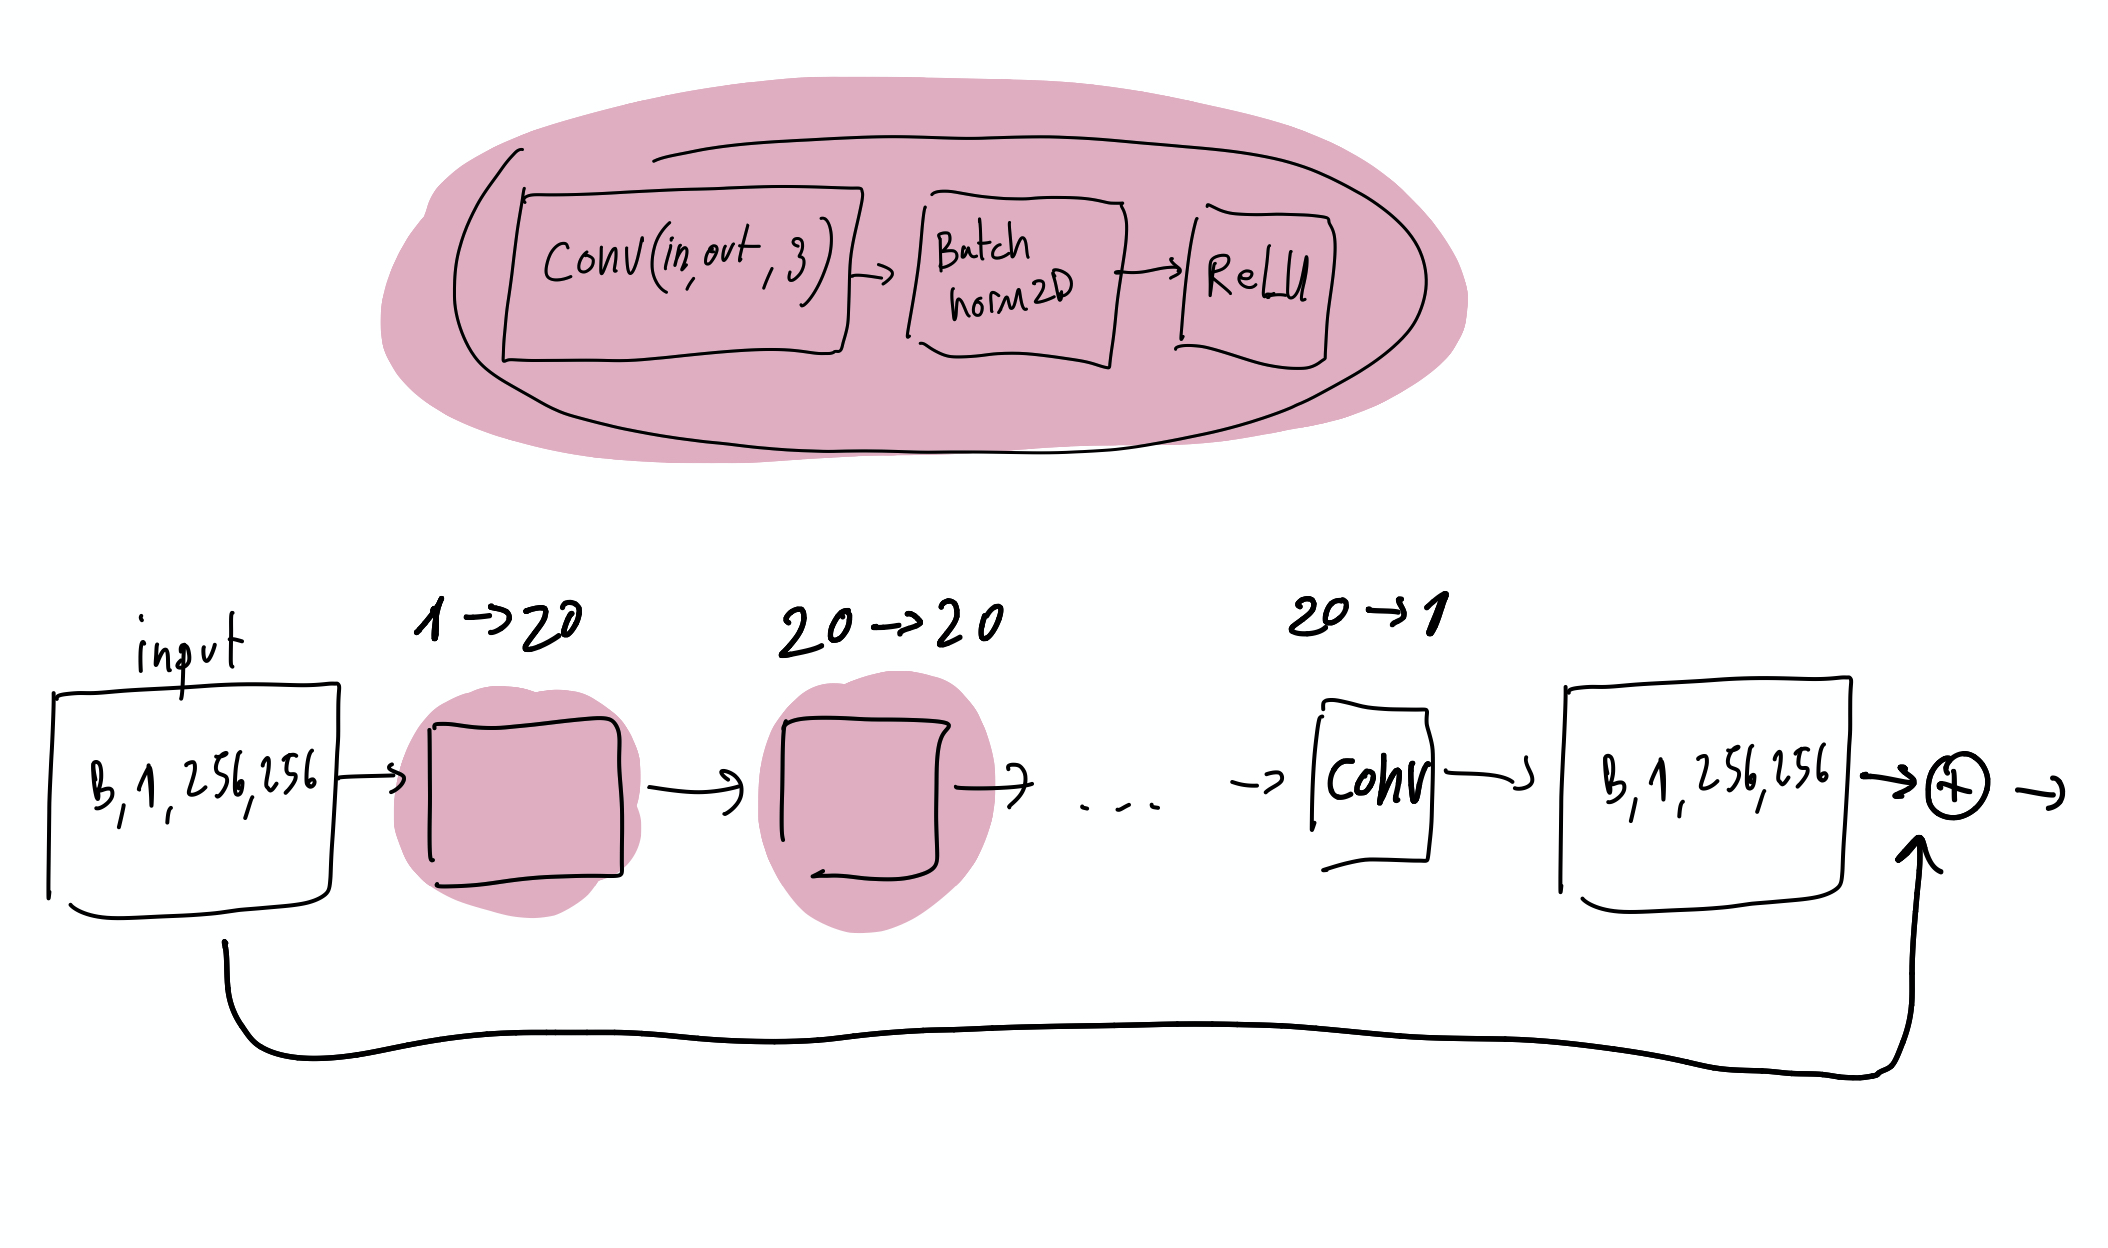

In [99]:
from model_denoise import Net

In [100]:
net = Net()

In [101]:
net(x).shape

torch.Size([4, 1, 256, 256])

In [102]:
import torch
import torch.nn as nn
import torch.optim as optim


loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4) 

In [103]:
def compute_loss(dataloader,net):
    
    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    n_batches = 0
    with torch.no_grad():
        for x,y in dataloader:
            n_batches+=1
            
            if torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            pred = net(x)
            
            loss+= loss_func(pred,y).item()
            
    loss = loss/n_batches      
    return loss

In [109]:
compute_loss(valid_dataloader,net)

0.00037053966661915183

In [105]:

n_epochs = 100


validation_loss_vs_epoch = []


if torch.cuda.is_available():
    net.cuda()
        
for epoch in range(n_epochs):
    
    if len(validation_loss_vs_epoch) > 0:
        print('epoch',epoch,' val loss:'+'{0:.5f}'.format(validation_loss_vs_epoch[-1]) )
    
    
    net.train() # put the net into "training mode"
    for x,y in training_dataloader:
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            
        optimizer.zero_grad()
        pred = net(x)
        loss = loss_func(pred,y)
        loss.backward()
        optimizer.step()
    
    net.eval() #put the net into evaluation mode
    
    valid_loss =  compute_loss(valid_dataloader,net)
         
    
    validation_loss_vs_epoch.append(valid_loss)
    
    if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
        torch.save(net.state_dict(), 'trained_model.pt')

epoch 1  val loss:0.00979
epoch 2  val loss:0.00652
epoch 3  val loss:0.00445
epoch 4  val loss:0.00359
epoch 5  val loss:0.00313
epoch 6  val loss:0.00282
epoch 7  val loss:0.00249
epoch 8  val loss:0.00217
epoch 9  val loss:0.00199
epoch 10  val loss:0.00194
epoch 11  val loss:0.00164
epoch 12  val loss:0.00167
epoch 13  val loss:0.00143
epoch 14  val loss:0.00137
epoch 15  val loss:0.00126
epoch 16  val loss:0.00122
epoch 17  val loss:0.00114
epoch 18  val loss:0.00108
epoch 19  val loss:0.00113
epoch 20  val loss:0.00097
epoch 21  val loss:0.00105
epoch 22  val loss:0.00088
epoch 23  val loss:0.00084
epoch 24  val loss:0.00103
epoch 25  val loss:0.00077
epoch 26  val loss:0.00084
epoch 27  val loss:0.00086
epoch 28  val loss:0.00075
epoch 29  val loss:0.00076
epoch 30  val loss:0.00094
epoch 31  val loss:0.00063
epoch 32  val loss:0.00067
epoch 33  val loss:0.00058
epoch 34  val loss:0.00055
epoch 35  val loss:0.00052
epoch 36  val loss:0.00069
epoch 37  val loss:0.00050
epoch 38  

KeyboardInterrupt: 

In [106]:
net.load_state_dict(torch.load('trained_model.pt',map_location='cpu'))

<All keys matched successfully>

### you can submit if you validation loss is < 0.01

try to get results that look decent

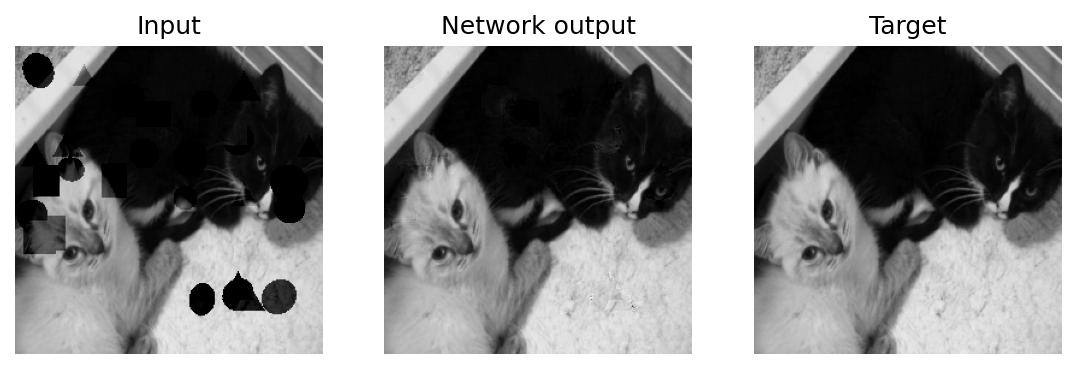

In [114]:
x, y = train_ds[40]

fig,ax = plt.subplots(1,3,figsize=(9,3),dpi=150)

ax[2].imshow(y[0],cmap='gist_yarg',vmin=0,vmax=1)
ax[0].imshow(x[0],cmap='gist_yarg',vmin=0,vmax=1)

net.eval()
net.cpu()
predicted = net( x.unsqueeze(1) )[0][0].data.numpy()

ax[1].imshow(predicted,cmap='gist_yarg',vmin=0,vmax=1)

ax[0].set_title('Input',fontsize=12)
ax[1].set_title('Network output',fontsize=12)
ax[2].set_title('Target',fontsize=12)
for i in range(3):
    ax[i].set_axis_off()

plt.show()

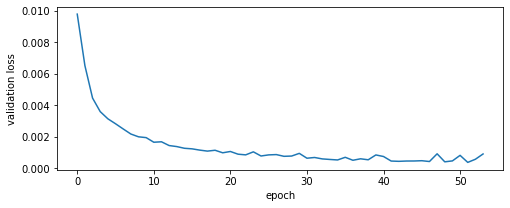

In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.plot(validation_loss_vs_epoch,label='validation')
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.show()